In [1]:
import pandas as pd
import torch
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings


In [2]:
import sqlite3

con = sqlite3.connect("../input/flipkart-cell-phone-reviews/flipkart_products.db")
items = pd.read_sql_query("SELECT * from items", con)
con.close()


In [3]:
items.head()


,product_id,product_name,price,category,sub_category,specifications,ratings,discount,moreinfo
0,ECMB000001,"Redmi 9A (SeaBlue, 32 GB)","₹7,413",Electronics,Mobile,2 GB RAM | 32 GB ROM16.59 cm (6.53 inch) Full ...,4.3,3.0,/redmi-9a-seablue-32-gb/p/itmeabd39a0cd669?pid...
1,ECMB000002,"Redmi 9A (Midnight Black, 32 GB)","₹7,421",Electronics,Mobile,2 GB RAM | 32 GB ROM16.59 cm (6.53 inch) Full ...,4.3,3.0,/redmi-9a-midnight-black-32-gb/p/itmeabd39a0cd...
2,ECMB000003,"Redmi 9A (Nature Green, 32 GB)","₹7,384",Electronics,Mobile,2 GB RAM | 32 GB ROM16.59 cm (6.53 inch) Full ...,4.3,4.0,/redmi-9a-nature-green-32-gb/p/itmeabd39a0cd66...
3,ECMB000004,"Redmi 9 (Carbon Black, 64 GB)","₹10,745",Electronics,Mobile,4 GB RAM | 64 GB ROM16.59 cm (6.53 inch) HD+ D...,4.2,None,/redmi-9-carbon-black-64-gb/p/itm4fb151383983b...
4,ECMB000005,"Redmi 9 (Sky Blue, 64 GB)","₹10,489",Electronics,Mobile,4 GB RAM | 64 GB ROM16.59 cm (6.53 inch) HD+ D...,4.2,None,/redmi-9-sky-blue-64-gb/p/itm4fb151383983b?pid...


In [4]:
items.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   product_id      82 non-null     object
 1   product_name    82 non-null     object
 2   price           82 non-null     object
 3   category        82 non-null     object
 4   sub_category    82 non-null     object
 5   specifications  82 non-null     object
 6   ratings         82 non-null     object
 7   discount        34 non-null     object
 8   moreinfo        82 non-null     object
dtypes: object(9)
memory usage: 5.9+ KB


Items dataset is just like an index for some book.

In [5]:

con = sqlite3.connect("../input/flipkart-cell-phone-reviews/flipkart_products.db")

df = pd.read_sql_query("SELECT * from ECMB000001", con)

for i in range(2, len(items) + 1):

    df_temp = pd.read_sql_query("SELECT * from ECMB{:06d}".format(i), con)
    df = pd.concat([df, df_temp])
con.close()


In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53493 entries, 0 to 289
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  53493 non-null  object
 1   review_id   53493 non-null  object
 2   title       53493 non-null  object
 3   review      53493 non-null  object
 4   likes       53493 non-null  object
 5   dislikes    53493 non-null  object
 6   ratings     48488 non-null  object
 7   reviewer    53493 non-null  object
dtypes: object(8)
memory usage: 3.7+ MB


In [7]:
df.head()

,product_id,review_id,title,review,likes,dislikes,ratings,reviewer
0,ECMB000001,ECMB0000010000001,Excellent,Wow superb I love it❤️👍 battery backup so nice 👍👍,740,160,5,Abhishek Saini
1,ECMB000001,ECMB0000010000002,Worth the money,Mobile So Good In Range Redmi 9a Has Miui 12 L...,355,104,4,Dinesh Kumar Sahni
2,ECMB000001,ECMB0000010000003,Just wow!,Wonderful device and smart phone best camera b...,125,47,5,Flipkart Customer
3,ECMB000001,ECMB0000010000004,Simply awesome,Very good mobile. Value for money. Battery bac...,0,0,5,Amit Sen
4,ECMB000001,ECMB0000010000005,Highly recommended,Really great.... value for money...,90,15,5,Sudeshna pakira


<Figure size 1800x1440 with 0 Axes>

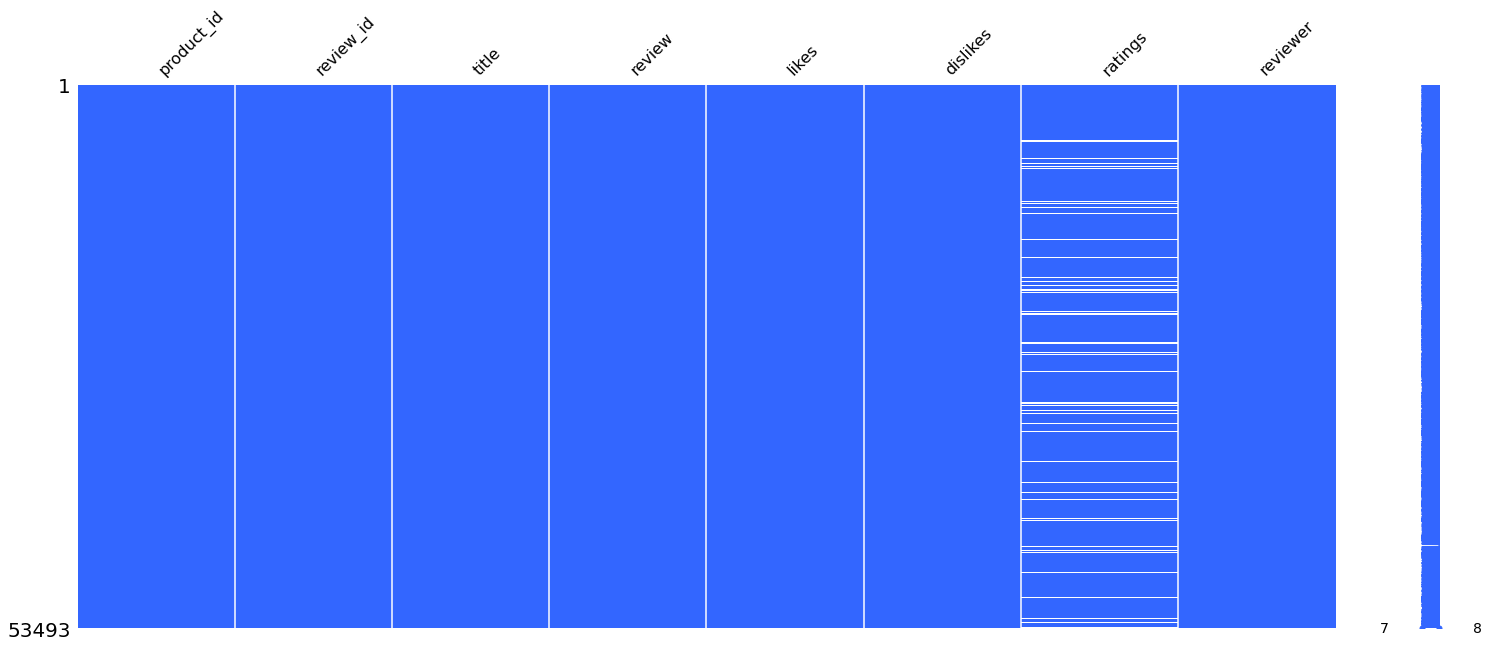

In [8]:
import missingno as msno
plt.figure(figsize=(25, 20))
msno.matrix(df, color=[0.2, 0.4, 1])
plt.show()

In [9]:
df.dropna(inplace=True, axis=0)
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 48488 entries, 0 to 287
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  48488 non-null  object
 1   review_id   48488 non-null  object
 2   title       48488 non-null  object
 3   review      48488 non-null  object
 4   likes       48488 non-null  object
 5   dislikes    48488 non-null  object
 6   ratings     48488 non-null  object
 7   reviewer    48488 non-null  object
dtypes: object(8)
memory usage: 3.3+ MB


<Figure size 1800x1440 with 0 Axes>

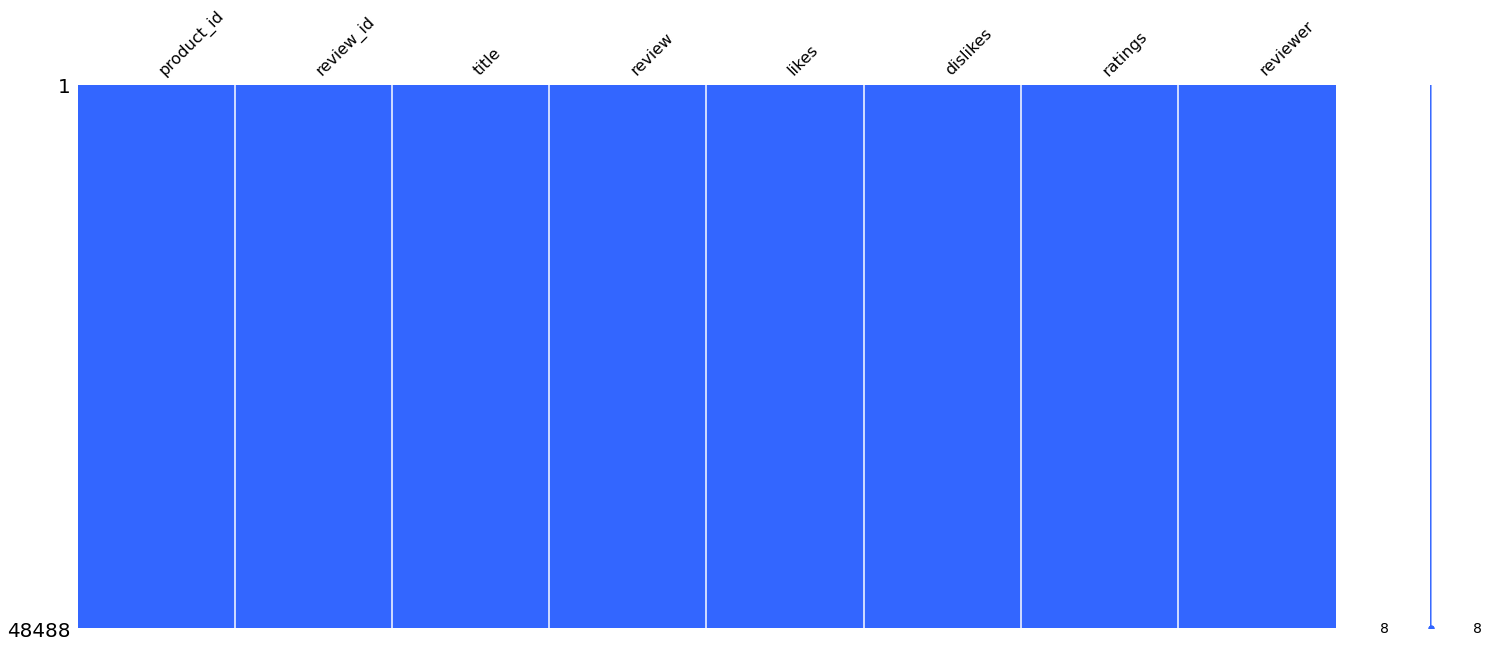

In [10]:
import missingno as msno
plt.figure(figsize=(25, 20))
msno.matrix(df, color=[0.2, 0.4, 1])
plt.show()


In [11]:
import re


def remove_url(text):
    text = re.sub(r"http\S+", "", text)
    return text


sample = "ℍ𝕚 𝔼𝕧𝕖𝕣𝕪𝕠𝕟𝕖 𝕀 𝕒𝕞 Hemanth 𝕙𝕒𝕧𝕚𝕟𝕘 good hold on python and react"
print(f"Text before removing url:- \n {sample}")

sample = remove_url(sample)
print(f"Text after removing url:- \n {sample}")


Text before removing url:- 
 ℍ𝕚 𝔼𝕧𝕖𝕣𝕪𝕠𝕟𝕖 𝕀 𝕒𝕞 𝔸𝕟𝕜𝕚𝕥 𝔾𝕦𝕡𝕥𝕒 𝕙𝕒𝕧𝕚𝕟𝕘 𝕥𝕙𝕖 𝕗𝕠𝕝𝕝𝕠𝕨𝕚𝕟𝕘 𝕂𝕒𝕘𝕘𝕝𝕖 𝕡𝕣𝕠𝕗𝕚𝕝𝕖 
 https://www.kaggle.com/nkitgupta 𝕒𝕟𝕕 𝕀 𝕒𝕞 😊 𝕥𝕠 𝕔𝕣𝕖𝕒𝕥𝕖 𝕥𝕙𝕚𝕤 𝕟𝕠𝕥𝕖𝕓𝕠𝕠𝕜
Text after removing url:- 
 ℍ𝕚 𝔼𝕧𝕖𝕣𝕪𝕠𝕟𝕖 𝕀 𝕒𝕞 𝔸𝕟𝕜𝕚𝕥 𝔾𝕦𝕡𝕥𝕒 𝕙𝕒𝕧𝕚𝕟𝕘 𝕥𝕙𝕖 𝕗𝕠𝕝𝕝𝕠𝕨𝕚𝕟𝕘 𝕂𝕒𝕘𝕘𝕝𝕖 𝕡𝕣𝕠𝕗𝕚𝕝𝕖 
  𝕒𝕟𝕕 𝕀 𝕒𝕞 😊 𝕥𝕠 𝕔𝕣𝕖𝕒𝕥𝕖 𝕥𝕙𝕚𝕤 𝕟𝕠𝕥𝕖𝕓𝕠𝕠𝕜


In [12]:
print("\u00C7", "\u0043\u0327")


Ç Ç


In [13]:
"\u00C7" == "\u0043\u0327"


False

In [14]:
"Ç" == "Ç"


False

In [16]:
!pip install demoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.7 MB/s eta 0:00:00


In [21]:
from nltk.corpus import stopwords

en_stopwords = set(stopwords.words('english'))
print(f"Stop Words in English : \n{ en_stopwords}")


Stop Words in English : 
{'while', 'these', 'with', 'won', 'y', 'their', "aren't", 'at', 'can', 'same', 'doing', 'having', 'an', 'shan', 'any', 'not', 'ma', 'you', 'those', "haven't", "couldn't", 'i', 'hers', 'couldn', 'because', "it's", 'that', 'by', 'does', 'why', 'only', 'how', 'each', 'other', 'did', "mustn't", "shan't", "she's", 'was', 'itself', "hasn't", 'yourselves', 'over', 'own', 'is', 'in', 'under', 'should', "mightn't", 'but', 'after', 'than', 'were', 'him', 'during', 'herself', 'don', 'such', "that'll", 'nor', 'if', 'she', 'we', 'who', 'are', 't', "you'd", 'll', 'needn', 'didn', 'then', 'some', "wasn't", 've', 'your', 'above', 'will', 're', 'more', 'my', 'yours', 'had', "don't", 'what', 'now', "wouldn't", 'into', 'mustn', 'which', 'have', 'me', "you're", "won't", 'do', "doesn't", "needn't", 'wouldn', 'about', 'doesn', 'all', 'until', 'isn', 'too', 'down', 'of', 'am', 'a', 'here', 'himself', 'be', 'on', 'whom', 'he', 'and', 'mightn', 'haven', 'themselves', 'out', 'there', 'f

In [22]:
def remove_stopwords(text):
    text = [word for word in text if word not in en_stopwords]
    return text


print(f"Before removing stopwords : {word_tokenizer(sample)}")
print(f"After removing stopwords : {remove_stopwords(word_tokenizer(sample))}")


Before removing stopwords : ['hi', 'everyone', 'i', 'am', 'ankit', 'gupta.']
After removing stopwords : ['hi', 'everyone', 'ankit', 'gupta.']


In [25]:
import spacy

sp = spacy.load("en_core_web_sm")

In [26]:
def lemmatization(text):

    # text = [sp(word).lemma_ for word in text]

    text = " ".join(text)
    token = sp(text)

    text = [word.lemma_ for word in token]
    return text


print(f"Before Lemmatization : {word_tokenizer(sample)}")
print(f"After Lemmatization : {lemmatization(word_tokenizer(sample))}")


Before Lemmatization : ['i', 'am', 'creating', 'a', 'notebook']
After Lemmatization : ['i', 'be', 'create', 'a', 'notebook']


In [32]:
df_temp = df_temp[['review', 'y', 'ratings']]

In [33]:
df_temp.head()

,review,y,ratings
0,Wow superb I love it❤️👍 battery backup so nice 👍👍,1,5
1,Mobile So Good In Range Redmi 9a Has Miui 12 L...,1,4
2,Wonderful device and smart phone best camera b...,1,5
3,Very good mobile. Value for money. Battery bac...,1,5
4,Really great.... value for money...,1,5


In [34]:
df_temp.y.value_counts()

1    44751
0     3737
Name: y, dtype: int64

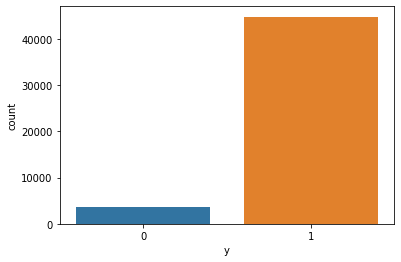

In [35]:
import seaborn as sns

sns.countplot(x = "y", data = df_temp)
plt.show()

In [36]:
df_temp2 = df_temp[(df_temp['ratings'] == '5')]

In [37]:
positive = list(df_temp2[(df_temp2['review'].str.len() > 100) & (df_temp2['review'].str.len() < 350)]['review'])
len(positive)

4803

In [38]:
!pip install nlpaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 7.8 MB/s eta 0:00:00a 0:00:01


In [39]:
import nlpaug.augmenter.word as naw

We used Python’s NLPAug to do the data augmentation task. First, we choose positive reviews of 100-350 character lengths which were 4803. Just have a look at few of the reviews in below shown image.

In [40]:
positive[41:49]

["An amazing smartphone for the price though i didn't like the colors compared to a realme phone in the same price range. It's a reall good second smartphone if you already have a primary device.",
 "Nice product according to its budget. But it's hard to play high Graphics games like pubg on 3GB RAM. It lags even when you play at Smooth Graphics settings. If this is for gaming (High graphics game) purpose, then don't go for 3GB or 2 GB RAM and the rest it works very well.",
 'I gave this phone to my wife as a gift and she loved it so much that she gets great performance and photos of games',
 'Every thing is great about the phone but a micro USB connector with a 5000 mah battery kind of suck a type c connector would have been better',
 'Very good handset at this price. Nice and great performance. Battery backup is also trustworthy. There is no issue till date after using for a period of 5days. Overall u can buy this phone without hesitation',
 'I am happy with your productus policy of 

In [41]:
aug = naw.AntonymAug(name='Antonym_Aug', aug_min=1, aug_max=10, aug_p=0.3, lang='eng', stopwords=en_stopwords, tokenizer=None, 
                     reverse_tokenizer=None, stopwords_regex=None, verbose=0)
 
aug_negative = aug.augment(positive)

In [42]:
len(aug_negative)

4803

In [43]:
aug_negative[41:49]

["An amazing smartphone for the price though i didn ' t like the colors compared to a realme phone in the same price range. It ' s a reall bad second smartphone if you already have a secondary device.",
 "Nice product according to its budget. But it ' s hard to play low Graphics games like pubg on 3GB RAM. It lags even when you play at Smooth Graphics settings. If this is for gaming (Low graphics game) purpose, then don ' t come for 3GB or 2 GB RAM and the rest it idle very badly.",
 'I take this phone to my wife as a gift and she hate it so little that she take away great performance and photos of games',
 'Every thing is great about the phone but a micro USB connector with a 5000 mah battery kind of suck a type c connector would have been ill',
 'Very bad handset at this price. Nice and great performance. Battery backup is also untrustworthy. There is no issue till date after using for a period of 5days. Overall u can sell this phone without hesitation',
 'I am unhappy with your prod

In [44]:
df_negative = pd.DataFrame({"review" : aug_negative, 'y' : [0]*len(aug_negative)})

In [45]:
df_positive = pd.DataFrame({"review" : positive, 'y' : [1]*len(positive)})

In [46]:
df_temp = pd.concat([df_negative, df_positive]).sample(frac = 1, random_state = 11).reset_index(drop=True)

In [47]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9606 entries, 0 to 9605
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  9606 non-null   object
 1   y       9606 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 150.2+ KB


In [48]:
df_temp.head()

,review,y
0,great phone in budget. .. pubg performance was...,0
1,Best Smartphone by Mi in this Range. . malfunc...,0
2,Bad smooth phone. . and back camera quality is...,0
3,Thise is very nice mobile ...I like it very mu...,1
4,I m meagerly fall short of 👍 All section r sup...,0


In [49]:
df = df_temp

Applying Text cleaning and preprocessing on whole dataset

In [50]:
def preprocessing(text):
    
    text = remove_url(text) 
    text = uni.normalize('NFKD', text)
    text = handle_emoji(text)
    text = text.lower() 
    text = re.sub(r'[^\w\s]', '', text)
    text = word_tokenizer(text)
    # text = stemming(text)
    text = lemmatization(text)
    text = remove_stopwords(text)
    text = " ".join(text)

    return text

In [51]:
from tqdm import tqdm

tqdm.pandas()

df['clean_review'] = df['review'].progress_map(preprocessing)

100%|██████████| 9606/9606 [01:46<00:00, 90.38it/s] 


In [52]:
df.head()

,review,y,clean_review
0,great phone in budget. .. pubg performance was...,0,great phone budget pubg performance rough came...
1,Best Smartphone by Mi in this Range. . malfunc...,0,good smartphone mi range malfunction -PRON- -P...
2,Bad smooth phone. . and back camera quality is...,0,bad smooth phone back camera quality bad rear ...
3,Thise is very nice mobile ...I like it very mu...,1,thise nice mobile like -PRON- much delivery al...
4,I m meagerly fall short of 👍 All section r sup...,0,meagerly fall short thumb section r superb del...


In [53]:
reviews = df.clean_review.values.tolist()


In [54]:
from tqdm import tqdm

tqdm.pandas()

df['clean_review2'] = df['clean_review'].progress_map(word_tokenizer)

100%|██████████| 9606/9606 [00:00<00:00, 246005.19it/s]


In [55]:
df.head()

,review,y,clean_review,clean_review2
0,great phone in budget. .. pubg performance was...,0,great phone budget pubg performance rough came...,"[great, phone, budget, pubg, performance, roug..."
1,Best Smartphone by Mi in this Range. . malfunc...,0,good smartphone mi range malfunction -PRON- -P...,"[good, smartphone, mi, range, malfunction, -pr..."
2,Bad smooth phone. . and back camera quality is...,0,bad smooth phone back camera quality bad rear ...,"[bad, smooth, phone, back, camera, quality, ba..."
3,Thise is very nice mobile ...I like it very mu...,1,thise nice mobile like -PRON- much delivery al...,"[thise, nice, mobile, like, -pron-, much, deli..."
4,I m meagerly fall short of 👍 All section r sup...,0,meagerly fall short thumb section r superb del...,"[meagerly, fall, short, thumb, section, r, sup..."


In [56]:
data_words = df['clean_review2'].values.tolist()
len(data_words)

9606

In [57]:
import gensim.corpora as corpora

id2word = corpora.Dictionary(data_words)

texts = data_words

corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1][0][:30])


[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 3), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)]


In [58]:
from gensim.models import LdaMulticore
from gensim.models import LdaModel
from pprint import pprint

num_topics = 10

lda_model = LdaMulticore(corpus=corpus, id2word=id2word,
                     num_topics=num_topics, iterations=400)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


[(0,
  '0.073*"-pron-" + 0.038*"good" + 0.036*"phone" + 0.030*"camera" + '
  '0.021*"battery" + 0.021*"mobile" + 0.015*"product" + 0.015*"bad" + '
  '0.014*"use" + 0.013*"money"'),
 (1,
  '0.035*"heart" + 0.035*"red" + 0.022*"10" + 0.021*"camera" + 0.020*"thumb" + '
  '0.019*"quality" + 0.018*"hand" + 0.018*"mobile" + 0.017*"evil" + '
  '0.017*"nasty"'),
 (2,
  '0.094*"-pron-" + 0.033*"camera" + 0.030*"good" + 0.029*"phone" + '
  '0.016*"mobile" + 0.015*"nice" + 0.015*"battery" + 0.015*"awesome" + '
  '0.013*"like" + 0.012*"performance"'),
 (3,
  '0.050*"phone" + 0.031*"bad" + 0.031*"camera" + 0.026*"battery" + '
  '0.026*"evil" + 0.023*"-pron-" + 0.023*"price" + 0.022*"good" + '
  '0.017*"performance" + 0.015*"great"'),
 (4,
  '0.035*"-pron-" + 0.031*"camera" + 0.025*"bad" + 0.024*"evil" + '
  '0.018*"battery" + 0.018*"flipkart" + 0.015*"phone" + 0.014*"great" + '
  '0.014*"also" + 0.012*"face"'),
 (5,
  '0.036*"phone" + 0.035*"good" + 0.026*"camera" + 0.021*"redmi" + '
  '0.021*"batt

In [59]:
%%time
from gensim.models import FastText
fasttext_model = FastText(data_words, vector_size= 100, window=5, min_count=5, workers=4,sg=1)


CPU times: user 12.6 s, sys: 176 ms, total: 12.8 s
Wall time: 7.22 s


In [60]:
fasttext_model.save("FastText-Model-For-ABSA.bin")

In [61]:
fasttext_model.wv.n_similarity("I really like the camera of this phone", "battery")

0.94390035

In [62]:
fasttext_model.wv.n_similarity("I really like the camera of this phone", "camera")

0.9008302

In [63]:
aspects = ["phone", "camera", "battery", "delivery", "processor"]

def get_similarity(text, aspect):
    try:
        text = " ".join(text)
        return fasttext_model.wv.n_similarity(text, aspect)
    except:
        return 0


In [64]:
from tqdm import tqdm
tqdm.pandas()
for aspect in aspects:
    df[aspect] = df['clean_review2'].progress_map(lambda text: get_similarity(text, aspect))

100%|██████████| 9606/9606 [00:09<00:00, 1003.71it/s]


In [65]:
df.head()

,review,y,clean_review,clean_review2,phone,camera,battery,delivery,processor
0,great phone in budget. .. pubg performance was...,0,great phone budget pubg performance rough came...,"[great, phone, budget, pubg, performance, roug...",0.907446,0.869852,0.946410,0.924622,0.900410
1,Best Smartphone by Mi in this Range. . malfunc...,0,good smartphone mi range malfunction -PRON- -P...,"[good, smartphone, mi, range, malfunction, -pr...",0.917733,0.815571,0.929728,0.902149,0.867337
2,Bad smooth phone. . and back camera quality is...,0,bad smooth phone back camera quality bad rear ...,"[bad, smooth, phone, back, camera, quality, ba...",0.873958,0.914712,0.952184,0.924982,0.934939
3,Thise is very nice mobile ...I like it very mu...,1,thise nice mobile like -PRON- much delivery al...,"[thise, nice, mobile, like, -pron-, much, deli...",0.929912,0.875874,0.934746,0.927503,0.903717
4,I m meagerly fall short of 👍 All section r sup...,0,meagerly fall short thumb section r superb del...,"[meagerly, fall, short, thumb, section, r, sup...",0.862345,0.880910,0.971365,0.960728,0.920727


In [66]:
df.to_csv("Clean_Flipkart_Product.csv", index = False)

--------------------------------------------
----------------

In [67]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler
import warnings

In [68]:
class config:
    warnings.filterwarnings("ignore", category = UserWarning)
    IMG_SIZE = (224,224)
    DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")
    FOLDS = 5
    SHUFFLE = True
    BATCH_SIZE = 32
    LR = 0.01
    EPOCHS = 30
    EMB_DIM = 100
    MAX_LEN = 20
    MODEL_PATH = "./Models/MyModel.pt"

In [69]:
# df = pd.read_csv("../input/mimobilereviews/Clean_Flipkart_Product.csv")
df.head()

,review,y,clean_review,clean_review2,phone,camera,battery,delivery,processor
0,great phone in budget. .. pubg performance was...,0,great phone budget pubg performance rough came...,"[great, phone, budget, pubg, performance, roug...",0.907446,0.869852,0.946410,0.924622,0.900410
1,Best Smartphone by Mi in this Range. . malfunc...,0,good smartphone mi range malfunction -PRON- -P...,"[good, smartphone, mi, range, malfunction, -pr...",0.917733,0.815571,0.929728,0.902149,0.867337
2,Bad smooth phone. . and back camera quality is...,0,bad smooth phone back camera quality bad rear ...,"[bad, smooth, phone, back, camera, quality, ba...",0.873958,0.914712,0.952184,0.924982,0.934939
3,Thise is very nice mobile ...I like it very mu...,1,thise nice mobile like -PRON- much delivery al...,"[thise, nice, mobile, like, -pron-, much, deli...",0.929912,0.875874,0.934746,0.927503,0.903717
4,I m meagerly fall short of 👍 All section r sup...,0,meagerly fall short thumb section r superb del...,"[meagerly, fall, short, thumb, section, r, sup...",0.862345,0.880910,0.971365,0.960728,0.920727


In [70]:
class Vocabulary:
  

    def __init__(self, freq_threshold, max_size):

        self.itos = {0: '<PAD>', 1:'<SOS>', 2:'<EOS>', 3: '<UNK>'}

        self.stoi = {k:j for j,k in self.itos.items()} 
        
        self.freq_threshold = freq_threshold
        self.max_size = max_size
    

    def __len__(self):
        return len(self.itos)
    

    @staticmethod
    def tokenizer(text):
        return [tok.lower().strip() for tok in text.split(' ')]

    def build_vocabulary(self, sentence_list):
        frequencies = {}  #init the freq dict
        idx = 4 
        for sentence in sentence_list:
            for word in self.tokenizer(sentence):
                if word not in frequencies.keys():
                    frequencies[word]=1
                else:
                    frequencies[word]+=1

        frequencies = {k:v for k,v in frequencies.items() if v>self.freq_threshold} 
        

        frequencies = dict(sorted(frequencies.items(), key = lambda x: -x[1])[:self.max_size-idx]) # idx =4 for pad, start, end , unk
  
        for word in frequencies.keys():
            self.stoi[word] = idx
            self.itos[idx] = word
            idx+=1
            

    def numericalize(self, text):
        #tokenize text
        tokenized_text = self.tokenizer(text)
        numericalized_text = []
        for token in tokenized_text:
            if token in self.stoi.keys():
                numericalized_text.append(self.stoi[token])
            else: #out-of-vocab words are represented by UNK token index
                numericalized_text.append(self.stoi['<UNK>'])
                
        return numericalized_text


In [71]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    
    def __init__(self, df, source_column,freq_threshold = 3,
                source_vocab_max_size = 10000 , transform=None):
    
        self.df = df
        self.transform = transform

        self.source_texts = self.df[source_column]
        

        self.source_vocab = Vocabulary(freq_threshold, source_vocab_max_size)
        self.source_vocab.build_vocabulary(self.source_texts.tolist())

        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        source_text = self.source_texts[index]
        
        if self.transform is not None:
            source_text = self.transform(source_text)

        numerialized_source = [self.source_vocab.stoi["<SOS>"]]
        numerialized_source += self.source_vocab.numericalize(source_text)
        numerialized_source.append(self.source_vocab.stoi["<EOS>"])
     
        return torch.tensor(numerialized_source), torch.tensor(self.df.y[index])

In [72]:
df.head()

,review,y,clean_review,clean_review2,phone,camera,battery,delivery,processor
0,great phone in budget. .. pubg performance was...,0,great phone budget pubg performance rough came...,"[great, phone, budget, pubg, performance, roug...",0.907446,0.869852,0.946410,0.924622,0.900410
1,Best Smartphone by Mi in this Range. . malfunc...,0,good smartphone mi range malfunction -PRON- -P...,"[good, smartphone, mi, range, malfunction, -pr...",0.917733,0.815571,0.929728,0.902149,0.867337
2,Bad smooth phone. . and back camera quality is...,0,bad smooth phone back camera quality bad rear ...,"[bad, smooth, phone, back, camera, quality, ba...",0.873958,0.914712,0.952184,0.924982,0.934939
3,Thise is very nice mobile ...I like it very mu...,1,thise nice mobile like -PRON- much delivery al...,"[thise, nice, mobile, like, -pron-, much, deli...",0.929912,0.875874,0.934746,0.927503,0.903717
4,I m meagerly fall short of 👍 All section r sup...,0,meagerly fall short thumb section r superb del...,"[meagerly, fall, short, thumb, section, r, sup...",0.862345,0.880910,0.971365,0.960728,0.920727


In [73]:
dataset = CustomDataset(df, "clean_review")

In [74]:
len(dataset.source_vocab.stoi)

3320

In [75]:
import pickle

with open('dataset-new', 'wb') as dataset_file:
 

    pickle.dump(dataset, dataset_file, pickle.HIGHEST_PROTOCOL)


In [76]:
def get_emb_layer_with_weights(target_vocab, emb_model, trainable = False):

    weights_matrix = np.zeros((len(target_vocab), config.EMB_DIM))
    words_found = 0
    
    for i, word in enumerate(target_vocab):
        weights_matrix[i] = np.concatenate([emb_model.wv[word]])
        words_found += 1
                
    print(f"Words found are : {words_found}")
    
    weights_matrix = torch.tensor(weights_matrix, dtype = torch.float32).reshape(len(target_vocab), config.EMB_DIM)
    emb_layer = nn.Embedding.from_pretrained(weights_matrix)
    print(emb_layer)
    if trainable:
        emb_layer.weight.requires_grad = True
    else:
        emb_layer.weight.requires_grad = False

    return emb_layer

In [77]:
class MyCollate:
    def __init__(self, pad_idx, maxlen):
        self.pad_idx = pad_idx
        self.maxlen = maxlen

    def __call__(self, batch):
        #get all source indexed sentences of the batch
        source = [item[0] for item in batch] 

        padded_sequence = torch.zeros((self.maxlen, len(batch)), dtype = torch.int)
        
        for idx, text in enumerate(source):
            
            if len(text) > self.maxlen:
                padded_sequence[:, idx] = source[idx][: self.maxlen]
            else:
                padded_sequence[:len(source[idx]), idx] = padded_sequence[:len(source[idx]), idx] + source[idx]
                
       
        target = [item[1] for item in batch] 
        
        target = torch.tensor(target, dtype = torch.float32).reshape(-1)
        return padded_sequence, target


<h2  style="text-align: center" class="list-group-item list-group-item-success"> 6.4 Initializing the Model </h2><a id = "6.4" ></a>

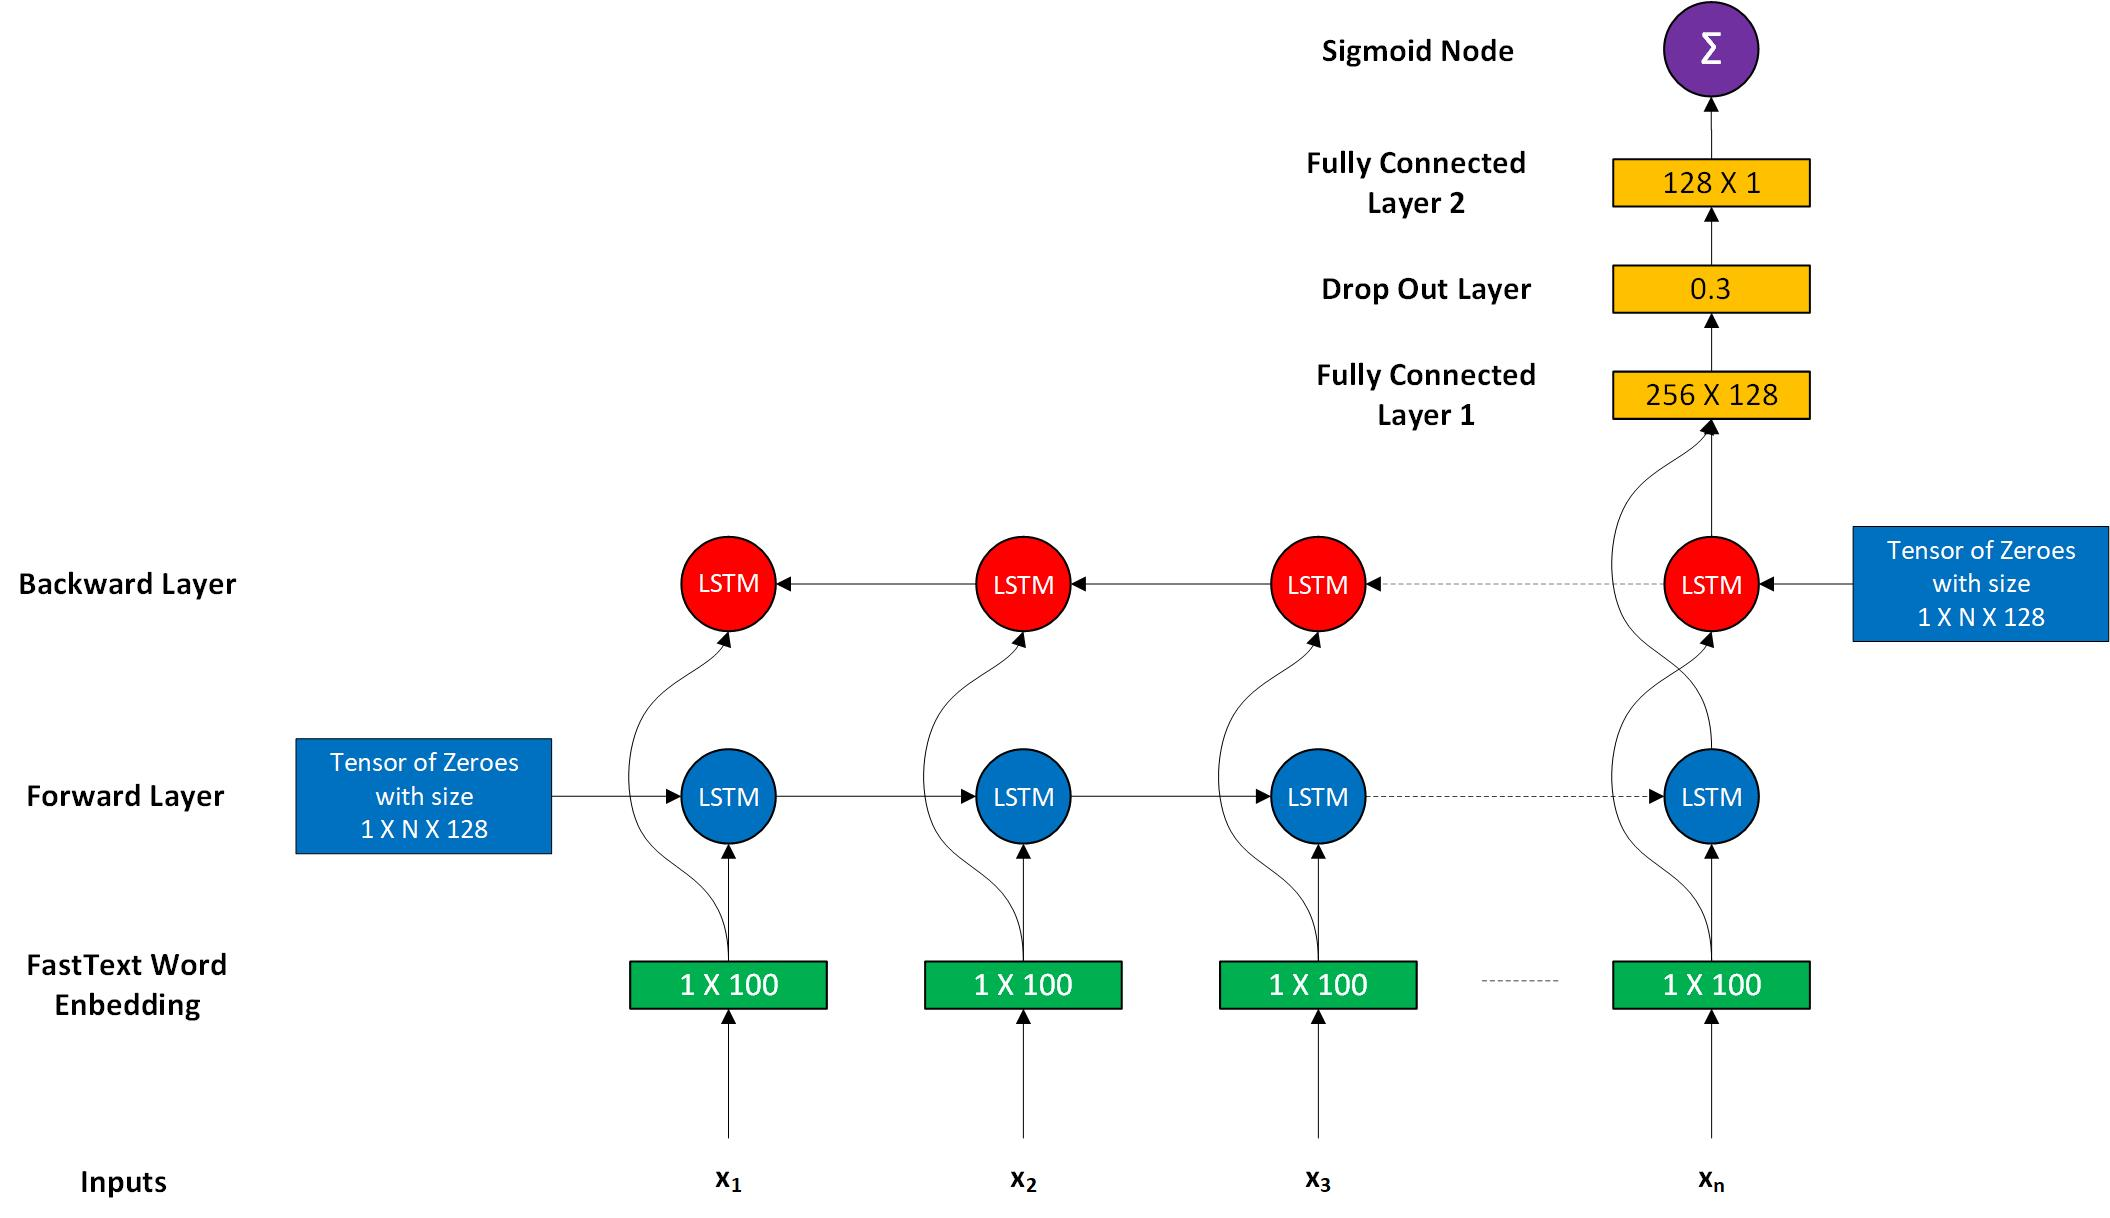

In [78]:
class Model(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, embedding_layer):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.embedding = embedding_layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional = True)
        self.fc1 = nn.Linear(2*hidden_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()


        
    def forward(self, text):
        
        max_len, N = text.shape
        hidden = torch.zeros((2, N , self.hidden_dim),
                          dtype=torch.float)
        memory = torch.zeros((2, N , self.hidden_dim),
                          dtype=torch.float)
        hidden = hidden.to(config.DEVICE)
        memory = memory.to(config.DEVICE)
        embedded = self.embedding(text)
        output, hidden = self.lstm(embedded, (hidden, memory))

        y_pred = output[-1,:,:]
        y_pred = self.fc1(y_pred)
        y_pred = self.fc2(y_pred)
        y_pred = self.sigmoid(y_pred)
                         
        return y_pred  

 <h2  style="text-align: center" class="list-group-item list-group-item-success"> 6.5 Training and K-fold Cross Validation </h2><a id = "6.5" ></a>

In [79]:
def train_epochs(dataloader,model, loss_fn, optimizer):
    train_correct = 0
    train_loss = 0
    
    model.train()

    for review, label in tqdm(dataloader):
        
        review, label = review.to(config.DEVICE), label.to(config.DEVICE)
        optimizer.zero_grad()
        output = model(review)
        output = output.reshape(-1)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*review.size(1)
        prediction = (output > 0.5).float()
        train_correct += (prediction == label).float().sum()
        
    return train_loss, train_correct

        

In [80]:
def val_epochs(dataloader, model, loss_fn):
    val_correct = 0
    val_loss = 0
    
    model.eval()

    for review, label in dataloader:
        
        review, label = review.to(config.DEVICE), label.to(config.DEVICE)
        
        output = model(review)
        output = output.reshape(-1)

        loss = loss_fn(output, label)
        
        val_loss += loss.item()*review.size(1)
        prediction = (output > 0.5).float()
        val_correct += (prediction == label).float().sum()

    return val_loss, val_correct

        

In [81]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler
from torch.optim import Adam
from tqdm import tqdm
from torch.utils.data import DataLoader 
import matplotlib.pyplot as plt


kfold = KFold(n_splits = config.FOLDS)
model_state_dicts = {}
 
for fold, (train_idx, val_idx) in enumerate(kfold.split(np.arange(len(dataset)))):
    
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    
    train_loader = DataLoader(dataset, batch_size = config.BATCH_SIZE, sampler = train_sampler, collate_fn = MyCollate(0, config.MAX_LEN))
    val_loader = DataLoader(dataset, batch_size = config.BATCH_SIZE, sampler = val_sampler, collate_fn = MyCollate(0, config.MAX_LEN))  
    
    VOCAB_SIZE = len(dataset.source_vocab)
    HIDDEN_DIM = 128
    OUTPUT_DIM = 1
    VOCAB = list(dataset.source_vocab.stoi)

    embedding_layer = get_emb_layer_with_weights(target_vocab = VOCAB, emb_model = fasttext_model, trainable = False)

    model = Model(VOCAB_SIZE, config.EMB_DIM, HIDDEN_DIM, OUTPUT_DIM, embedding_layer)
    model = model.to(config.DEVICE)
    

    loss_fn = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    print(f"-----------------------------------------------------------{fold}-fold of the model-----------------------------------------------------------")
    for epoch in range(config.EPOCHS):
        train_loss, train_correct = train_epochs(train_loader, model, loss_fn, optimizer)
        val_loss, val_correct = val_epochs(val_loader, model, loss_fn)  
        
        train_loss = train_loss/len(train_loader.sampler)
        val_loss = val_loss/len(val_loader.sampler)
        train_acc = (train_correct/len(train_loader.sampler))*100
        val_acc = (val_correct/len(val_loader.sampler))*100
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc.cpu().numpy().tolist())
        val_accs.append(val_acc.cpu().numpy().tolist())
        
        print(f"| Train Loss : {train_loss} |", end = " ")
        print(f" Val Loss : {val_loss} |", end = " ")
        print(f"Train Acc : {train_acc} |", end = " ")
        print(f"Val Acc : {val_acc} |")

        
    model_state_dicts.update({f"LSTM-Model-for-{fold}" : model.state_dict(),
                             f"Model-Optimizer-for-{fold}" : optimizer.state_dict()})
    


Words found are : 3320
Embedding(3320, 100)
-----------------------------------------------------------0-fold of the model-----------------------------------------------------------


100%|██████████| 241/241 [00:02<00:00, 96.92it/s] 


| Train Loss : 0.691445683855864 |  Val Loss : 0.6912261053501133 | Train Acc : 52.14732360839844 | Val Acc : 49.0634765625 |


100%|██████████| 241/241 [00:01<00:00, 189.71it/s]


| Train Loss : 0.6863167701072832 |  Val Loss : 0.6803484888404266 | Train Acc : 56.988548278808594 | Val Acc : 59.00104522705078 |


100%|██████████| 241/241 [00:01<00:00, 206.26it/s]


| Train Loss : 0.624527019768069 |  Val Loss : 0.3219369961865611 | Train Acc : 66.59292602539062 | Val Acc : 91.51925659179688 |


100%|██████████| 241/241 [00:01<00:00, 204.40it/s]


| Train Loss : 0.3688831619456806 |  Val Loss : 0.7171020234908819 | Train Acc : 85.15097045898438 | Val Acc : 61.03017807006836 |


100%|██████████| 241/241 [00:01<00:00, 204.37it/s]


| Train Loss : 0.2759155514477939 |  Val Loss : 0.17276899728237902 | Train Acc : 89.62779998779297 | Val Acc : 93.4963607788086 |


100%|██████████| 241/241 [00:01<00:00, 207.93it/s]


| Train Loss : 0.24562578330680396 |  Val Loss : 1.4342712680581458 | Train Acc : 90.61686706542969 | Val Acc : 56.711761474609375 |


100%|██████████| 241/241 [00:01<00:00, 210.25it/s]


| Train Loss : 0.22019720169822726 |  Val Loss : 0.13708961113868717 | Train Acc : 91.38469696044922 | Val Acc : 95.62955474853516 |


100%|██████████| 241/241 [00:01<00:00, 211.24it/s]


| Train Loss : 0.1910525613359211 |  Val Loss : 0.2678236482542834 | Train Acc : 92.63404846191406 | Val Acc : 88.76171112060547 |


100%|██████████| 241/241 [00:01<00:00, 205.97it/s]


| Train Loss : 0.19617163187851824 |  Val Loss : 0.13216609131006 | Train Acc : 92.38677978515625 | Val Acc : 95.52549743652344 |


100%|██████████| 241/241 [00:01<00:00, 193.45it/s]


| Train Loss : 0.18653122455711665 |  Val Loss : 0.22251448168590834 | Train Acc : 92.7121353149414 | Val Acc : 90.58272552490234 |


100%|██████████| 241/241 [00:01<00:00, 209.00it/s]


| Train Loss : 0.17924612561577252 |  Val Loss : 0.14186922854183748 | Train Acc : 92.89432525634766 | Val Acc : 94.95317840576172 |


100%|██████████| 241/241 [00:01<00:00, 206.81it/s]


| Train Loss : 0.18021902401254303 |  Val Loss : 0.1849568238914106 | Train Acc : 92.92035675048828 | Val Acc : 92.14360809326172 |


100%|██████████| 241/241 [00:01<00:00, 209.59it/s]


| Train Loss : 0.1729844487444311 |  Val Loss : 0.1358529641200923 | Train Acc : 93.46694946289062 | Val Acc : 94.84912109375 |


100%|██████████| 241/241 [00:01<00:00, 211.98it/s]


| Train Loss : 0.16940191746890576 |  Val Loss : 0.12395988448942613 | Train Acc : 93.37584686279297 | Val Acc : 95.3173828125 |


100%|██████████| 241/241 [00:01<00:00, 209.92it/s]


| Train Loss : 0.1655870460629277 |  Val Loss : 0.4487748011698584 | Train Acc : 93.80531311035156 | Val Acc : 73.20500183105469 |


100%|██████████| 241/241 [00:01<00:00, 167.18it/s]


| Train Loss : 0.17690427533075997 |  Val Loss : 0.37080033409479973 | Train Acc : 93.05049896240234 | Val Acc : 83.9229965209961 |


100%|██████████| 241/241 [00:01<00:00, 196.74it/s]


| Train Loss : 0.16544730507539374 |  Val Loss : 0.1289871387836852 | Train Acc : 93.27173614501953 | Val Acc : 94.90115356445312 |


100%|██████████| 241/241 [00:01<00:00, 189.75it/s]


| Train Loss : 0.15976406914656638 |  Val Loss : 0.11985787150763076 | Train Acc : 93.74024200439453 | Val Acc : 95.68158721923828 |


100%|██████████| 241/241 [00:01<00:00, 205.72it/s]


| Train Loss : 0.15660696394255755 |  Val Loss : 0.12068930860612692 | Train Acc : 93.83134460449219 | Val Acc : 95.52549743652344 |


100%|██████████| 241/241 [00:01<00:00, 209.00it/s]


| Train Loss : 0.15415857725799517 |  Val Loss : 0.11632233451854178 | Train Acc : 94.07860565185547 | Val Acc : 95.83767700195312 |


100%|██████████| 241/241 [00:01<00:00, 208.93it/s]


| Train Loss : 0.14968476681458584 |  Val Loss : 0.12034599853216299 | Train Acc : 94.07860565185547 | Val Acc : 95.73361206054688 |


100%|██████████| 241/241 [00:01<00:00, 209.86it/s]


| Train Loss : 0.15163002157354033 |  Val Loss : 0.18456063326157468 | Train Acc : 94.02655029296875 | Val Acc : 91.6233139038086 |


100%|██████████| 241/241 [00:01<00:00, 209.30it/s]


| Train Loss : 0.151184461572591 |  Val Loss : 0.1246028013147499 | Train Acc : 94.22176361083984 | Val Acc : 95.16129302978516 |


100%|██████████| 241/241 [00:01<00:00, 211.80it/s]


| Train Loss : 0.14851597926149387 |  Val Loss : 0.3657314714575409 | Train Acc : 94.09162139892578 | Val Acc : 83.03850555419922 |


100%|██████████| 241/241 [00:01<00:00, 213.42it/s]


| Train Loss : 0.14824213982253825 |  Val Loss : 0.11266586222587993 | Train Acc : 94.28683471679688 | Val Acc : 95.78564453125 |


100%|██████████| 241/241 [00:01<00:00, 193.70it/s]


| Train Loss : 0.1466854943528787 |  Val Loss : 0.15268127370962986 | Train Acc : 94.22176361083984 | Val Acc : 93.91259765625 |


100%|██████████| 241/241 [00:01<00:00, 211.19it/s]


| Train Loss : 0.144726484098638 |  Val Loss : 0.12070647660452916 | Train Acc : 94.13066864013672 | Val Acc : 95.3694076538086 |


100%|██████████| 241/241 [00:01<00:00, 210.36it/s]


| Train Loss : 0.14296317846055653 |  Val Loss : 0.1174530624484684 | Train Acc : 94.56012725830078 | Val Acc : 95.73361206054688 |


100%|██████████| 241/241 [00:01<00:00, 208.12it/s]


| Train Loss : 0.14312503342058575 |  Val Loss : 0.1286074775314728 | Train Acc : 94.41697692871094 | Val Acc : 95.10926818847656 |


100%|██████████| 241/241 [00:01<00:00, 210.38it/s]


| Train Loss : 0.1416993139312641 |  Val Loss : 0.11242704002746806 | Train Acc : 94.29985046386719 | Val Acc : 95.99376678466797 |
Words found are : 3320
Embedding(3320, 100)
-----------------------------------------------------------1-fold of the model-----------------------------------------------------------


100%|██████████| 241/241 [00:01<00:00, 209.28it/s]


| Train Loss : 0.6922102223609126 |  Val Loss : 0.6902342086530862 | Train Acc : 51.08653259277344 | Val Acc : 57.522125244140625 |


100%|██████████| 241/241 [00:01<00:00, 211.75it/s]


| Train Loss : 0.6871537447983984 |  Val Loss : 0.6815995257822938 | Train Acc : 56.79895782470703 | Val Acc : 63.61270523071289 |


100%|██████████| 241/241 [00:01<00:00, 209.23it/s]


| Train Loss : 0.6260898333520337 |  Val Loss : 0.36169768422299037 | Train Acc : 67.65127563476562 | Val Acc : 90.57782745361328 |


100%|██████████| 241/241 [00:01<00:00, 192.65it/s]


| Train Loss : 0.37147328778762045 |  Val Loss : 0.45859980843825493 | Train Acc : 84.76252746582031 | Val Acc : 81.62415313720703 |


100%|██████████| 241/241 [00:01<00:00, 199.92it/s]


| Train Loss : 0.2575803301515871 |  Val Loss : 1.191578254706766 | Train Acc : 90.25373840332031 | Val Acc : 52.316505432128906 |


100%|██████████| 241/241 [00:01<00:00, 205.94it/s]


| Train Loss : 0.2194785439975865 |  Val Loss : 0.19346258251451223 | Train Acc : 91.60702514648438 | Val Acc : 92.13951110839844 |


100%|██████████| 241/241 [00:01<00:00, 189.60it/s]


| Train Loss : 0.20642645790949998 |  Val Loss : 0.18397279593168542 | Train Acc : 92.12751770019531 | Val Acc : 93.02446746826172 |


100%|██████████| 241/241 [00:01<00:00, 208.73it/s]


| Train Loss : 0.18362421249666613 |  Val Loss : 0.36255908407462895 | Train Acc : 93.07743072509766 | Val Acc : 85.89276885986328 |


100%|██████████| 241/241 [00:01<00:00, 150.23it/s]


| Train Loss : 0.17130387216011425 |  Val Loss : 0.21432060781451315 | Train Acc : 93.11646270751953 | Val Acc : 92.035400390625 |


100%|██████████| 241/241 [00:01<00:00, 209.49it/s]


| Train Loss : 0.16914579369607652 |  Val Loss : 1.9042120508574247 | Train Acc : 93.55888366699219 | Val Acc : 50.2342529296875 |


100%|██████████| 241/241 [00:01<00:00, 204.39it/s]


| Train Loss : 0.19835331283882987 |  Val Loss : 0.4562877693750693 | Train Acc : 92.16655731201172 | Val Acc : 86.25715637207031 |


100%|██████████| 241/241 [00:01<00:00, 187.84it/s]


| Train Loss : 0.15589826123991335 |  Val Loss : 0.2858060935099126 | Train Acc : 94.07937622070312 | Val Acc : 90.31755065917969 |


100%|██████████| 241/241 [00:01<00:00, 203.48it/s]


| Train Loss : 0.15363821566163058 |  Val Loss : 0.20637811838374326 | Train Acc : 94.17046356201172 | Val Acc : 91.04633331298828 |


100%|██████████| 241/241 [00:01<00:00, 207.58it/s]


| Train Loss : 0.14925346113329363 |  Val Loss : 0.23412836898304426 | Train Acc : 94.3135986328125 | Val Acc : 92.2436294555664 |


100%|██████████| 241/241 [00:01<00:00, 208.07it/s]


| Train Loss : 0.14726990572647686 |  Val Loss : 0.2627850636289121 | Train Acc : 94.30058288574219 | Val Acc : 91.098388671875 |


100%|██████████| 241/241 [00:01<00:00, 207.52it/s]


| Train Loss : 0.14857912613109248 |  Val Loss : 0.380053768005224 | Train Acc : 94.13143157958984 | Val Acc : 87.350341796875 |


100%|██████████| 241/241 [00:01<00:00, 203.48it/s]


| Train Loss : 0.1415699482875438 |  Val Loss : 0.28711902465863287 | Train Acc : 94.43070983886719 | Val Acc : 90.78604888916016 |


100%|██████████| 241/241 [00:01<00:00, 204.27it/s]


| Train Loss : 0.1432949266003211 |  Val Loss : 0.16396055792549016 | Train Acc : 94.41769409179688 | Val Acc : 93.80531311035156 |


100%|██████████| 241/241 [00:01<00:00, 198.88it/s]


| Train Loss : 0.13986798988421317 |  Val Loss : 0.1632843708371252 | Train Acc : 94.66493225097656 | Val Acc : 93.75325775146484 |


100%|██████████| 241/241 [00:01<00:00, 190.50it/s]


| Train Loss : 0.14122868301946773 |  Val Loss : 0.20576010192979569 | Train Acc : 94.4697494506836 | Val Acc : 92.2436294555664 |


100%|██████████| 241/241 [00:01<00:00, 205.25it/s]


| Train Loss : 0.1381528615981835 |  Val Loss : 0.1712627599819649 | Train Acc : 94.63890838623047 | Val Acc : 93.59709167480469 |


100%|██████████| 241/241 [00:01<00:00, 209.97it/s]


| Train Loss : 0.1375184250870694 |  Val Loss : 0.6514174610699727 | Train Acc : 94.78204345703125 | Val Acc : 76.52265167236328 |


100%|██████████| 241/241 [00:01<00:00, 212.05it/s]


| Train Loss : 0.13917925579712115 |  Val Loss : 0.16628698080017937 | Train Acc : 94.5998764038086 | Val Acc : 93.38886260986328 |


100%|██████████| 241/241 [00:01<00:00, 209.50it/s]


| Train Loss : 0.13605700374890553 |  Val Loss : 1.666710360108534 | Train Acc : 94.72999572753906 | Val Acc : 60.281105041503906 |


100%|██████████| 241/241 [00:01<00:00, 201.56it/s]


| Train Loss : 0.13555282024726048 |  Val Loss : 0.3782253032478706 | Train Acc : 94.5998764038086 | Val Acc : 87.6106185913086 |


100%|██████████| 241/241 [00:01<00:00, 209.46it/s]


| Train Loss : 0.13508409810050712 |  Val Loss : 0.17280529579887033 | Train Acc : 94.75601959228516 | Val Acc : 92.972412109375 |


100%|██████████| 241/241 [00:01<00:00, 210.14it/s]


| Train Loss : 0.1323116239013057 |  Val Loss : 0.15846579905204478 | Train Acc : 94.78204345703125 | Val Acc : 93.85736846923828 |


100%|██████████| 241/241 [00:01<00:00, 193.40it/s]


| Train Loss : 0.13217404976865263 |  Val Loss : 0.5785375832890794 | Train Acc : 94.80806732177734 | Val Acc : 80.73919677734375 |


100%|██████████| 241/241 [00:01<00:00, 212.81it/s]


| Train Loss : 0.13463145964666862 |  Val Loss : 0.1637176200068754 | Train Acc : 94.84710693359375 | Val Acc : 93.59709167480469 |


100%|██████████| 241/241 [00:01<00:00, 208.47it/s]


| Train Loss : 0.13171184115698373 |  Val Loss : 0.19476611243598727 | Train Acc : 94.74300384521484 | Val Acc : 92.39979553222656 |
Words found are : 3320
Embedding(3320, 100)
-----------------------------------------------------------2-fold of the model-----------------------------------------------------------


100%|██████████| 241/241 [00:01<00:00, 185.32it/s]


| Train Loss : 0.6922777735574259 |  Val Loss : 0.6929354645944027 | Train Acc : 51.5029296875 | Val Acc : 48.620513916015625 |


100%|██████████| 241/241 [00:01<00:00, 171.83it/s]


| Train Loss : 0.6882394699516743 |  Val Loss : 0.6841345660578516 | Train Acc : 55.83604431152344 | Val Acc : 58.927642822265625 |


100%|██████████| 241/241 [00:01<00:00, 203.21it/s]


| Train Loss : 0.649682862838523 |  Val Loss : 0.48011715253276915 | Train Acc : 65.5953140258789 | Val Acc : 81.15565490722656 |


100%|██████████| 241/241 [00:01<00:00, 206.23it/s]


| Train Loss : 0.40479416354530884 |  Val Loss : 0.20358920622692636 | Train Acc : 83.44828033447266 | Val Acc : 92.50390625 |


100%|██████████| 241/241 [00:01<00:00, 208.52it/s]


| Train Loss : 0.2790442444655557 |  Val Loss : 0.1813654633649062 | Train Acc : 89.12166595458984 | Val Acc : 92.972412109375 |


100%|██████████| 241/241 [00:01<00:00, 205.86it/s]


| Train Loss : 0.2318668963851755 |  Val Loss : 0.20677231538329102 | Train Acc : 90.91737365722656 | Val Acc : 93.28475189208984 |


100%|██████████| 241/241 [00:01<00:00, 208.05it/s]


| Train Loss : 0.21095687560470522 |  Val Loss : 1.6308756559730382 | Train Acc : 91.80221557617188 | Val Acc : 55.700157165527344 |


100%|██████████| 241/241 [00:01<00:00, 207.52it/s]


| Train Loss : 0.2010224087601291 |  Val Loss : 0.21369001102953264 | Train Acc : 92.16655731201172 | Val Acc : 92.08746337890625 |


100%|██████████| 241/241 [00:01<00:00, 211.22it/s]


| Train Loss : 0.1917767910336471 |  Val Loss : 0.4008734311088183 | Train Acc : 92.2836685180664 | Val Acc : 85.78865814208984 |


100%|██████████| 241/241 [00:01<00:00, 214.46it/s]


| Train Loss : 0.1793605666852416 |  Val Loss : 0.5171840057409195 | Train Acc : 93.12947082519531 | Val Acc : 79.43779754638672 |


100%|██████████| 241/241 [00:01<00:00, 209.78it/s]


| Train Loss : 0.17155167921824974 |  Val Loss : 0.159276038784493 | Train Acc : 93.50682830810547 | Val Acc : 93.64913940429688 |


100%|██████████| 241/241 [00:01<00:00, 142.05it/s]


| Train Loss : 0.17232178493088418 |  Val Loss : 0.19399367223984867 | Train Acc : 93.25959777832031 | Val Acc : 92.13951110839844 |


100%|██████████| 241/241 [00:01<00:00, 192.64it/s]


| Train Loss : 0.16886418345775128 |  Val Loss : 0.15358248515895004 | Train Acc : 93.51984405517578 | Val Acc : 93.44091796875 |


100%|██████████| 241/241 [00:01<00:00, 213.21it/s]


| Train Loss : 0.16629498568130202 |  Val Loss : 0.15534072862172044 | Train Acc : 93.51984405517578 | Val Acc : 94.1176528930664 |


100%|██████████| 241/241 [00:01<00:00, 212.22it/s]


| Train Loss : 0.15836499855358568 |  Val Loss : 0.15238752145124312 | Train Acc : 93.58490753173828 | Val Acc : 94.74232482910156 |


100%|██████████| 241/241 [00:01<00:00, 212.39it/s]


| Train Loss : 0.1560182618131169 |  Val Loss : 0.15238212510026636 | Train Acc : 94.0923843383789 | Val Acc : 94.32587432861328 |


100%|██████████| 241/241 [00:01<00:00, 210.68it/s]


| Train Loss : 0.15328189329272676 |  Val Loss : 0.15174470028177267 | Train Acc : 94.02732849121094 | Val Acc : 94.27381896972656 |


100%|██████████| 241/241 [00:01<00:00, 204.34it/s]


| Train Loss : 0.1547895091302843 |  Val Loss : 0.15366108760585304 | Train Acc : 93.76708221435547 | Val Acc : 94.42998504638672 |


100%|██████████| 241/241 [00:01<00:00, 212.71it/s]


| Train Loss : 0.1492187255715967 |  Val Loss : 0.17898106834192345 | Train Acc : 94.11841583251953 | Val Acc : 92.60802459716797 |


100%|██████████| 241/241 [00:01<00:00, 211.67it/s]


| Train Loss : 0.14896474154393397 |  Val Loss : 0.22180240045707403 | Train Acc : 94.24854278564453 | Val Acc : 91.87923431396484 |


100%|██████████| 241/241 [00:01<00:00, 195.44it/s]


| Train Loss : 0.14454498332219226 |  Val Loss : 0.238452767909583 | Train Acc : 94.4046859741211 | Val Acc : 90.78604888916016 |


100%|██████████| 241/241 [00:01<00:00, 212.22it/s]


| Train Loss : 0.14594945422456726 |  Val Loss : 0.3298992261645432 | Train Acc : 94.39167022705078 | Val Acc : 82.82144927978516 |


100%|██████████| 241/241 [00:01<00:00, 212.87it/s]


| Train Loss : 0.14197578719861334 |  Val Loss : 0.27409722190738145 | Train Acc : 94.49577331542969 | Val Acc : 85.7365951538086 |


100%|██████████| 241/241 [00:01<00:00, 156.45it/s]


| Train Loss : 0.14547157286652398 |  Val Loss : 0.15650928758869198 | Train Acc : 94.49577331542969 | Val Acc : 93.44091796875 |


100%|██████████| 241/241 [00:01<00:00, 209.39it/s]


| Train Loss : 0.14082860741497696 |  Val Loss : 0.1496925699019893 | Train Acc : 94.61288452148438 | Val Acc : 94.01353454589844 |


100%|██████████| 241/241 [00:01<00:00, 208.00it/s]


| Train Loss : 0.13751692912973362 |  Val Loss : 0.2473660240968896 | Train Acc : 94.69095611572266 | Val Acc : 90.8381118774414 |


100%|██████████| 241/241 [00:01<00:00, 213.47it/s]


| Train Loss : 0.1370322670065298 |  Val Loss : 0.16576925086857192 | Train Acc : 94.76902770996094 | Val Acc : 93.38886260986328 |


100%|██████████| 241/241 [00:01<00:00, 212.82it/s]


| Train Loss : 0.14101371360238624 |  Val Loss : 0.15500782681498163 | Train Acc : 94.30058288574219 | Val Acc : 93.64913940429688 |


100%|██████████| 241/241 [00:01<00:00, 197.57it/s]


| Train Loss : 0.13548575499729437 |  Val Loss : 0.19857470427078855 | Train Acc : 94.80806732177734 | Val Acc : 92.035400390625 |


100%|██████████| 241/241 [00:01<00:00, 215.61it/s]


| Train Loss : 0.13624594649693836 |  Val Loss : 0.15516561150108693 | Train Acc : 94.74300384521484 | Val Acc : 93.28475189208984 |
Words found are : 3320
Embedding(3320, 100)
-----------------------------------------------------------3-fold of the model-----------------------------------------------------------


100%|██████████| 241/241 [00:01<00:00, 215.04it/s]


| Train Loss : 0.6914822443708942 |  Val Loss : 0.6892257102264333 | Train Acc : 52.36174392700195 | Val Acc : 51.22332763671875 |


100%|██████████| 241/241 [00:01<00:00, 211.74it/s]


| Train Loss : 0.6851620197373702 |  Val Loss : 0.6739756459993723 | Train Acc : 56.85101318359375 | Val Acc : 65.22644805908203 |


100%|██████████| 241/241 [00:01<00:00, 212.58it/s]


| Train Loss : 0.5899474299101374 |  Val Loss : 1.0284390594385553 | Train Acc : 70.25373840332031 | Val Acc : 49.7657470703125 |


100%|██████████| 241/241 [00:01<00:00, 213.28it/s]


| Train Loss : 0.3451404008740485 |  Val Loss : 0.3572216565133631 | Train Acc : 86.36304473876953 | Val Acc : 84.74752807617188 |


100%|██████████| 241/241 [00:01<00:00, 199.08it/s]


| Train Loss : 0.254378725083214 |  Val Loss : 1.3293725576567843 | Train Acc : 89.86337280273438 | Val Acc : 54.34669876098633 |


100%|██████████| 241/241 [00:01<00:00, 212.21it/s]


| Train Loss : 0.2455903396213993 |  Val Loss : 0.5964072575557052 | Train Acc : 90.35784149169922 | Val Acc : 75.95002746582031 |


100%|██████████| 241/241 [00:01<00:00, 197.15it/s]


| Train Loss : 0.214391454259296 |  Val Loss : 0.8131300039445901 | Train Acc : 91.67208862304688 | Val Acc : 69.70327758789062 |


100%|██████████| 241/241 [00:01<00:00, 211.67it/s]


| Train Loss : 0.19134589056535906 |  Val Loss : 0.5997599213772425 | Train Acc : 92.49187469482422 | Val Acc : 76.10619354248047 |


100%|██████████| 241/241 [00:01<00:00, 215.07it/s]


| Train Loss : 0.1800884231125176 |  Val Loss : 0.17476331914606844 | Train Acc : 92.86922454833984 | Val Acc : 93.54502868652344 |


100%|██████████| 241/241 [00:01<00:00, 213.79it/s]


| Train Loss : 0.18033376214135058 |  Val Loss : 0.17107160996795012 | Train Acc : 92.93428802490234 | Val Acc : 93.80531311035156 |


100%|██████████| 241/241 [00:01<00:00, 208.51it/s]


| Train Loss : 0.16661341661901233 |  Val Loss : 0.2048519613063239 | Train Acc : 93.38971710205078 | Val Acc : 90.94222259521484 |


100%|██████████| 241/241 [00:01<00:00, 211.07it/s]


| Train Loss : 0.17468310671367077 |  Val Loss : 0.17915009213480584 | Train Acc : 93.24658203125 | Val Acc : 93.59709167480469 |


100%|██████████| 241/241 [00:01<00:00, 211.92it/s]


| Train Loss : 0.16793692467192511 |  Val Loss : 0.17280818517904056 | Train Acc : 93.48080444335938 | Val Acc : 92.7121353149414 |


100%|██████████| 241/241 [00:01<00:00, 209.52it/s]


| Train Loss : 0.1589855588387235 |  Val Loss : 0.16059419743700717 | Train Acc : 94.02732849121094 | Val Acc : 94.37793731689453 |


100%|██████████| 241/241 [00:01<00:00, 207.14it/s]


| Train Loss : 0.16080939676964057 |  Val Loss : 0.30979175223408484 | Train Acc : 93.76708221435547 | Val Acc : 85.84071350097656 |


100%|██████████| 241/241 [00:01<00:00, 208.09it/s]


| Train Loss : 0.16230561605175362 |  Val Loss : 0.20299178810052299 | Train Acc : 93.5458755493164 | Val Acc : 92.972412109375 |


100%|██████████| 241/241 [00:01<00:00, 155.10it/s]


| Train Loss : 0.1624133750655741 |  Val Loss : 0.15850118228963023 | Train Acc : 93.64996337890625 | Val Acc : 93.85736846923828 |


100%|██████████| 241/241 [00:01<00:00, 204.06it/s]


| Train Loss : 0.1517641912091453 |  Val Loss : 0.30337138004690206 | Train Acc : 94.06636047363281 | Val Acc : 85.6845474243164 |


100%|██████████| 241/241 [00:01<00:00, 208.66it/s]


| Train Loss : 0.15108400960013552 |  Val Loss : 0.15891089151142662 | Train Acc : 94.17046356201172 | Val Acc : 93.44091796875 |


100%|██████████| 241/241 [00:01<00:00, 208.95it/s]


| Train Loss : 0.15000307510571195 |  Val Loss : 0.15196559913669758 | Train Acc : 94.10540008544922 | Val Acc : 94.01353454589844 |


100%|██████████| 241/241 [00:01<00:00, 211.32it/s]


| Train Loss : 0.15005838565683513 |  Val Loss : 0.14835102254023533 | Train Acc : 94.26155090332031 | Val Acc : 94.32587432861328 |


100%|██████████| 241/241 [00:01<00:00, 212.12it/s]


| Train Loss : 0.14723992854570056 |  Val Loss : 0.23335139786573453 | Train Acc : 94.2745590209961 | Val Acc : 89.74492645263672 |


100%|██████████| 241/241 [00:01<00:00, 193.87it/s]


| Train Loss : 0.143393570089697 |  Val Loss : 0.14501473897624953 | Train Acc : 94.43070983886719 | Val Acc : 94.48204803466797 |


100%|██████████| 241/241 [00:01<00:00, 206.47it/s]


| Train Loss : 0.14698987027512658 |  Val Loss : 0.14752294862413085 | Train Acc : 94.24854278564453 | Val Acc : 94.63821411132812 |


100%|██████████| 241/241 [00:01<00:00, 209.01it/s]


| Train Loss : 0.14002643812377497 |  Val Loss : 0.2908944600901214 | Train Acc : 94.378662109375 | Val Acc : 89.27642059326172 |


100%|██████████| 241/241 [00:01<00:00, 212.05it/s]


| Train Loss : 0.1452437519406683 |  Val Loss : 0.21889238865858934 | Train Acc : 94.3135986328125 | Val Acc : 89.38053131103516 |


100%|██████████| 241/241 [00:01<00:00, 208.43it/s]


| Train Loss : 0.138383788174829 |  Val Loss : 0.1935316309867837 | Train Acc : 94.4697494506836 | Val Acc : 92.2436294555664 |


100%|██████████| 241/241 [00:01<00:00, 213.38it/s]


| Train Loss : 0.13643203329830567 |  Val Loss : 0.1419771754709865 | Train Acc : 94.87313079833984 | Val Acc : 94.63821411132812 |


100%|██████████| 241/241 [00:01<00:00, 216.14it/s]


| Train Loss : 0.13692952726053276 |  Val Loss : 0.15399889360176655 | Train Acc : 94.61288452148438 | Val Acc : 94.16970825195312 |


100%|██████████| 241/241 [00:01<00:00, 214.82it/s]


| Train Loss : 0.1367520026416653 |  Val Loss : 0.1540827030680634 | Train Acc : 94.45673370361328 | Val Acc : 94.48204803466797 |
Words found are : 3320
Embedding(3320, 100)
-----------------------------------------------------------4-fold of the model-----------------------------------------------------------


100%|██████████| 241/241 [00:01<00:00, 199.85it/s]


| Train Loss : 0.6921413538746036 |  Val Loss : 0.690647407660318 | Train Acc : 52.55693054199219 | Val Acc : 58.3029670715332 |


100%|██████████| 241/241 [00:01<00:00, 205.03it/s]


| Train Loss : 0.6878389633081916 |  Val Loss : 0.68420371538894 | Train Acc : 56.86402130126953 | Val Acc : 60.17699432373047 |


100%|██████████| 241/241 [00:01<00:00, 212.59it/s]


| Train Loss : 0.662002211626893 |  Val Loss : 0.659329332283299 | Train Acc : 63.175018310546875 | Val Acc : 54.190528869628906 |


100%|██████████| 241/241 [00:01<00:00, 210.19it/s]


| Train Loss : 0.43716614518409125 |  Val Loss : 0.24899531537855993 | Train Acc : 80.76773071289062 | Val Acc : 92.19157409667969 |


100%|██████████| 241/241 [00:01<00:00, 212.48it/s]


| Train Loss : 0.3007932617668991 |  Val Loss : 0.24394938513396122 | Train Acc : 88.34092712402344 | Val Acc : 91.098388671875 |


100%|██████████| 241/241 [00:01<00:00, 211.97it/s]


| Train Loss : 0.2288796964797713 |  Val Loss : 0.7963049981446393 | Train Acc : 91.12557220458984 | Val Acc : 67.15252685546875 |


100%|██████████| 241/241 [00:01<00:00, 214.08it/s]


| Train Loss : 0.2211684766272174 |  Val Loss : 0.25365168551823736 | Train Acc : 91.5029296875 | Val Acc : 90.78604888916016 |


100%|██████████| 241/241 [00:01<00:00, 210.25it/s]


| Train Loss : 0.20113700251279806 |  Val Loss : 0.18545368884121421 | Train Acc : 92.59596252441406 | Val Acc : 92.60802459716797 |


100%|██████████| 241/241 [00:01<00:00, 210.28it/s]


| Train Loss : 0.1894798685609325 |  Val Loss : 0.4098162686666556 | Train Acc : 92.62199401855469 | Val Acc : 84.22696685791016 |


100%|██████████| 241/241 [00:01<00:00, 141.44it/s]


| Train Loss : 0.17957211803007453 |  Val Loss : 0.16785438926594756 | Train Acc : 93.31165313720703 | Val Acc : 93.1806411743164 |


100%|██████████| 241/241 [00:01<00:00, 213.51it/s]


| Train Loss : 0.1816993508495211 |  Val Loss : 0.18178571802639112 | Train Acc : 93.10344696044922 | Val Acc : 93.1806411743164 |


100%|██████████| 241/241 [00:01<00:00, 202.97it/s]


| Train Loss : 0.17963371689036906 |  Val Loss : 0.357029276130416 | Train Acc : 93.2856216430664 | Val Acc : 86.77772521972656 |


100%|██████████| 241/241 [00:01<00:00, 210.86it/s]


| Train Loss : 0.17228625718075188 |  Val Loss : 0.16460982286010106 | Train Acc : 93.53285217285156 | Val Acc : 93.80531311035156 |


100%|██████████| 241/241 [00:01<00:00, 207.48it/s]


| Train Loss : 0.16589388872945782 |  Val Loss : 1.4374853068897728 | Train Acc : 93.64996337890625 | Val Acc : 52.47267532348633 |


100%|██████████| 241/241 [00:01<00:00, 209.85it/s]


| Train Loss : 0.18103316256421373 |  Val Loss : 0.6528074493938243 | Train Acc : 93.02537536621094 | Val Acc : 77.14732360839844 |


100%|██████████| 241/241 [00:01<00:00, 208.27it/s]


| Train Loss : 0.17402942172683675 |  Val Loss : 0.2757399522159821 | Train Acc : 93.36369323730469 | Val Acc : 85.7365951538086 |


100%|██████████| 241/241 [00:01<00:00, 192.49it/s]


| Train Loss : 0.1595678011947975 |  Val Loss : 0.20195284662045876 | Train Acc : 94.07937622070312 | Val Acc : 91.51483917236328 |


100%|██████████| 241/241 [00:01<00:00, 214.36it/s]


| Train Loss : 0.16060420803909925 |  Val Loss : 0.15033471693632905 | Train Acc : 93.96226501464844 | Val Acc : 94.01353454589844 |


100%|██████████| 241/241 [00:01<00:00, 208.56it/s]


| Train Loss : 0.15611245768398008 |  Val Loss : 0.14949584331165636 | Train Acc : 94.43070983886719 | Val Acc : 93.909423828125 |


100%|██████████| 241/241 [00:01<00:00, 208.69it/s]


| Train Loss : 0.15406096301034877 |  Val Loss : 0.15191928387444054 | Train Acc : 94.17046356201172 | Val Acc : 94.1176528930664 |


100%|██████████| 241/241 [00:01<00:00, 211.84it/s]


| Train Loss : 0.15336218511682093 |  Val Loss : 0.17955380844006597 | Train Acc : 94.17046356201172 | Val Acc : 92.50390625 |


100%|██████████| 241/241 [00:01<00:00, 210.39it/s]


| Train Loss : 0.15006833645765394 |  Val Loss : 0.16363385653259976 | Train Acc : 94.07937622070312 | Val Acc : 93.909423828125 |


100%|██████████| 241/241 [00:01<00:00, 210.75it/s]


| Train Loss : 0.14752903913008988 |  Val Loss : 0.30881605874058604 | Train Acc : 94.65191650390625 | Val Acc : 87.45445251464844 |


100%|██████████| 241/241 [00:01<00:00, 210.10it/s]


| Train Loss : 0.151549717758721 |  Val Loss : 0.2672843700677219 | Train Acc : 94.2745590209961 | Val Acc : 90.10932159423828 |


100%|██████████| 241/241 [00:01<00:00, 198.17it/s]


| Train Loss : 0.14622330475179265 |  Val Loss : 0.14758710827029278 | Train Acc : 94.10540008544922 | Val Acc : 94.1176528930664 |


100%|██████████| 241/241 [00:01<00:00, 200.59it/s]


| Train Loss : 0.14328986234337615 |  Val Loss : 0.14948917210164137 | Train Acc : 94.58686065673828 | Val Acc : 93.909423828125 |


100%|██████████| 241/241 [00:01<00:00, 203.13it/s]


| Train Loss : 0.14364665600658433 |  Val Loss : 0.1469274180235156 | Train Acc : 94.56082916259766 | Val Acc : 94.32587432861328 |


100%|██████████| 241/241 [00:01<00:00, 210.01it/s]


| Train Loss : 0.14046026826910396 |  Val Loss : 0.1579812755756723 | Train Acc : 94.83409881591797 | Val Acc : 93.96148681640625 |


100%|██████████| 241/241 [00:01<00:00, 155.64it/s]


| Train Loss : 0.14342561518517732 |  Val Loss : 0.15310915723105603 | Train Acc : 94.72999572753906 | Val Acc : 94.22176361083984 |


100%|██████████| 241/241 [00:01<00:00, 207.01it/s]


| Train Loss : 0.14079803515737058 |  Val Loss : 0.1476421425238306 | Train Acc : 94.69095611572266 | Val Acc : 94.06559753417969 |


In [82]:
torch.save(model_state_dicts, "My-Model.pt")

In [83]:
def numericalize(text):
    
    numerialized_source = [] 
    numerialized_source = [dataset.source_vocab.stoi["<SOS>"]]
    numerialized_source += dataset.source_vocab.numericalize(text)
    numerialized_source.append(dataset.source_vocab.stoi["<EOS>"])
    
    return numerialized_source

def padding(source):
    padded_sequence = torch.zeros(config.MAX_LEN, 1, dtype = torch.int)
    source = torch.tensor(source)
    
    if len(source) > config.MAX_LEN:
        padded_sequence[:, 0] = source[: config.MAX_LEN]
    else:
        padded_sequence[:len(source), 0] = padded_sequence[:len(source), 0] + source
    
    return padded_sequence

In [84]:
def infer_processing(text):
    
    text = preprocessing(text)
    text = numericalize(text)
    text = padding(text)
    return text

In [85]:
aspects = ["phone", "camera", "battery", "neutral", "processor"]

def get_similarity(text, aspect):
    try:
#         text = " ".join(text)
        return fasttext_model.wv.n_similarity(text, aspect)
    except:
        return 0
    
def best_aspect(text, aspects):
    a = []
    
    for aspect in aspects:
        a.append(get_similarity(text, aspect))
    
    return aspects[np.argmax(a)]


In [86]:

sample = "I am really impressed with the phone's great battery backup."

ba = best_aspect(preprocessing(sample), aspects)

a = infer_processing(sample).to(config.DEVICE)

In [87]:
model.eval()
sentiment = model(a)
sentiment = sentiment.cpu().detach().numpy()[0]

if sentiment > 0.5:
    sentiment = 'Positively'
else :
    sentiment = 'Negatively'

In [88]:
print(f"The reviewer is talking {sentiment} about the {ba} of the phone in his/her comment")

The reviewer is talking Positively about the battery of the phone in his/her comment
